In [162]:
import numpy as np 
import torch 
from torch.utils.data import TensorDataset,Dataset,DataLoader,random_split
import pandas as pd
from tqdm import tqdm

import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [163]:
#----------------------Load the Excel file-----------------------
def load_data(file_path, sheet_name):
    sheet_name = sheet_name
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    index_tensor = (df['A_position_counted_from_5_end_of_gRNA'] + 20).astype(int) 
    return df, index_tensor

In [164]:
import pandas as pd
import torch

class FeatureProcessor:
    def __init__(self, file_path='D:/01IscBML/', file_name = 'train.xlsx'):
        self.category_map = {'A': 0, 'T': 1, 'C': 2, 'G': 3}
        self.data_path = file_path + file_name
        self.df, self.index_tensor = self.load_data(self.data_path)  # load the df and index tensor as self attributes
        self.combined_features, self.sequence_length = self.feature_processing()
        self.labels_tensor = self.label()

    def __len__(self):
        return len(self.df.shape[0])

    def load_data(self, data_path):
        df = pd.read_excel(data_path)
        index_tensor = (df['A_position_counted_from_5_end_of_gRNA'] + 20).astype(int)-1 # Warning: 0-indexed
        return df, index_tensor

    def sequence_to_one_hot(self, sequence, categories="ATCG"):
        category_map = {char: idx for idx, char in enumerate(categories)}
        one_hot = []
        for char in sequence:
            one_hot_char = [0] * len(categories)
            if char in category_map:
                one_hot_char[category_map[char]] = 1
            one_hot.append(one_hot_char)
        return one_hot

    def feature_processing(self):
        sequence_data = self.df['Target_Site_sequence']
        sequence_length = len(sequence_data.iloc[0])
        one_hot_features = sequence_data.apply(self.sequence_to_one_hot)

        features_tensor = torch.tensor(list(one_hot_features), dtype=torch.float32)

        index_one_hot_features = []
        for idx in self.index_tensor:
            index_one_hot = [0] * sequence_length
            if 0 <= idx < sequence_length:
                index_one_hot[idx] = 1
            index_one_hot_features.append(index_one_hot)

        index_one_hot_tensor = torch.tensor(index_one_hot_features, dtype=torch.float32).unsqueeze(2)

        combined_features = torch.cat((features_tensor, index_one_hot_tensor), dim=2)
        return combined_features, sequence_length
    
    def label(self):
        #---------------------Prepare labels tensor-----------------------
        labels_tensor = torch.tensor(self.df['a-to-g(%)'].values/100, dtype=torch.float32).unsqueeze(1)  # Add a dimension for labels
        return labels_tensor
    



In [165]:
label_data = FeatureProcessor(file_path='D:/01IscBML/').labels_tensor
combined_features = FeatureProcessor(file_path='D:/01IscBML/').combined_features

In [166]:
sequence_length = FeatureProcessor(file_path='D:/01IscBML/').sequence_length

In [167]:
sequence_length

56

In [168]:
#---------------------Prepare labels tensor-----------------------
# labels_tensor = torch.tensor(df['a-to-g(%)'].values/100, dtype=torch.float32).unsqueeze(1)  # Add a dimension for labels

#---------------------Create dataset and dataloader-----------------
dataset = TensorDataset(combined_features, label_data)

# Turn shuffle to False if you want to keep the predefined order of the data
dataloader = DataLoader(dataset, batch_size=256, shuffle=False)  # You can adjust the batch size as needed
i= 0
# #----------------------Example to check batches---------------------
# for i, (batch_features, batch_labels) in enumerate(dataloader):
#     print("Batch", i)
#     print("Features Batch Shape:", batch_features[20,20:36,:])  # (batch_size, sequence_length, channel_size)
#     print("Labels Batch Shape:", batch_labels[20])  # (batch_size, 1)
#     i+=1
#     if i == 2:
#         break


In [169]:
# Define a simple 1D CNN model
# class CNN(nn.Module):
#     def __init__(self, sequence_length):
#         super(CNN, self).__init__()
#         self.conv1 = nn.Conv1d(in_channels=5, out_channels=16, kernel_size=3, padding=1)  # Update in_channels to 5
#         self.relu = nn.ReLU()
#         self.pool = nn.MaxPool1d(kernel_size=2)
        
#         # Dynamically compute the size of the flattened feature map
#         self.flattened_size = 16 * (sequence_length // 2)  # After one max pooling (sequence_length // 2)
#         self.fc1 = nn.Linear(self.flattened_size, 1)  # Fully connected layer
        
#     def forward(self, x):
#         x = x.permute(0, 2, 1)  # Change shape to (batch_size, channels, sequence_length)
#         x = self.conv1(x)
#         x = self.relu(x)
#         x = self.pool(x)
#         x = x.view(x.size(0), -1)  # Flatten
#         x = self.fc1(x)
#         return x

# class OptimizedCNN(nn.Module):
#     def __init__(self, sequence_length):
#         super(OptimizedCNN, self).__init__()
#         self.conv1 = nn.Conv1d(in_channels=5, out_channels=16, kernel_size=3, padding=1)  # 卷积层
#         self.relu = nn.ReLU()
        
#         # 计算全连接层输入的维度
#         self.flattened_size = 16 * sequence_length  # 无池化层时，序列长度不变
#         self.fc1 = nn.Linear(self.flattened_size, 1)  # 全连接层

#     def forward(self, x):
#         x = x.permute(0, 2, 1)  # 调整维度为 (batch_size, channels, sequence_length)
#         x = self.conv1(x)
#         x = self.relu(x)
#         x = x.view(x.size(0), -1)  # 展平
#         x = self.fc1(x)
#         return x

In [170]:
class LocalCNN(nn.Module):
    def __init__(self, sequence_length, kernel_size=21):
        super(LocalCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=5, out_channels=32, kernel_size=kernel_size, padding=kernel_size // 2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=kernel_size, padding=kernel_size // 2)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=kernel_size, padding=kernel_size // 2)
        self.relu = nn.ReLU()
        self.hardtanh = nn.Hardtanh(min_val=0, max_val=1)
        # self.clipper = nn.clippedReLU()
        self.fc1 = nn.Linear(32 * sequence_length, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Change shape to (batch_size, channels, sequence_length)
        x = self.conv1(x)  # Apply convolution
        x = self.relu(x)
        x = self.conv2(x) # Apply convolution
        x = self.relu(x)
        x = self.conv3(x)  # Apply convolution
        # x = self.relu(x)
        x = x.view(x.size(0), -1)  # Flatten for fully connected layer
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.hardtanh(x)
        x = self.fc3(x)
        return x


class MLP(nn.Module):
    def __init__(self, sequence_length):
        super(MLP, self).__init__()
        input_size = sequence_length * 5  # Flattened input size
        hidden_size = 512  # Number of neurons in each hidden layer
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),  # Add dropout for regularization
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, 1),  # Final output layer
            nn.Hardtanh(min_val=0, max_val=1)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input to (batch_size, sequence_length * 5)
        x = self.layers(x)
        return x

In [171]:
#------------------split train&validation dataset---------------------
from torch.utils.data import random_split, DataLoader

dataset_size = len(dataset)
train_size = int(0.8 * dataset_size) 
val_size = dataset_size - train_size  
print(val_size)

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=val_size, shuffle=False) 

for i, train_data in enumerate(train_dataloader):
    print("Batch", i)
    channel = train_data[0].shape[2]
    print("Features Batch Shape:", train_data[0].shape)  # (batch_size, sequence_length, channel_size)
    print("Labels Batch Shape:", train_data[1].shape)  # (batch_size, 1)
    i+=1
    if i == 2:
        break

5576
Batch 0
Features Batch Shape: torch.Size([256, 56, 5])
Labels Batch Shape: torch.Size([256, 1])
Batch 1
Features Batch Shape: torch.Size([256, 56, 5])
Labels Batch Shape: torch.Size([256, 1])


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 56]           3,392
              ReLU-2               [-1, 32, 56]               0
            Conv1d-3               [-1, 32, 56]          21,536
              ReLU-4               [-1, 32, 56]               0
            Conv1d-5               [-1, 32, 56]          21,536
            Linear-6                  [-1, 128]         229,504
              ReLU-7                  [-1, 128]               0
            Linear-8                   [-1, 32]           4,128
          Hardtanh-9                   [-1, 32]               0
           Linear-10                    [-1, 1]              33
Total params: 280,129
Trainable params: 280,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 1.07
Estimated T

Epoch 1/100: 100%|██████████| 88/88 [00:05<00:00, 16.78it/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 56]           3,392
              ReLU-2               [-1, 32, 56]               0
            Conv1d-3               [-1, 32, 56]          21,536
              ReLU-4               [-1, 32, 56]               0
            Conv1d-5               [-1, 32, 56]          21,536
            Linear-6                  [-1, 128]         229,504
              ReLU-7                  [-1, 128]               0
            Linear-8                   [-1, 32]           4,128
          Hardtanh-9                   [-1, 32]               0
           Linear-10                    [-1, 1]              33
Total params: 280,129
Trainable params: 280,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 1.07
Estimated T

Epoch 2/100: 100%|██████████| 88/88 [00:04<00:00, 18.51it/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 56]           3,392
              ReLU-2               [-1, 32, 56]               0
            Conv1d-3               [-1, 32, 56]          21,536
              ReLU-4               [-1, 32, 56]               0
            Conv1d-5               [-1, 32, 56]          21,536
            Linear-6                  [-1, 128]         229,504
              ReLU-7                  [-1, 128]               0
            Linear-8                   [-1, 32]           4,128
          Hardtanh-9                   [-1, 32]               0
           Linear-10                    [-1, 1]              33
Total params: 280,129
Trainable params: 280,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 1.07
Estimated T

Epoch 3/100: 100%|██████████| 88/88 [00:05<00:00, 17.22it/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 56]           3,392
              ReLU-2               [-1, 32, 56]               0
            Conv1d-3               [-1, 32, 56]          21,536
              ReLU-4               [-1, 32, 56]               0
            Conv1d-5               [-1, 32, 56]          21,536
            Linear-6                  [-1, 128]         229,504
              ReLU-7                  [-1, 128]               0
            Linear-8                   [-1, 32]           4,128
          Hardtanh-9                   [-1, 32]               0
           Linear-10                    [-1, 1]              33
Total params: 280,129
Trainable params: 280,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 1.07
Estimated T

Epoch 4/100: 100%|██████████| 88/88 [00:04<00:00, 17.74it/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 56]           3,392
              ReLU-2               [-1, 32, 56]               0
            Conv1d-3               [-1, 32, 56]          21,536
              ReLU-4               [-1, 32, 56]               0
            Conv1d-5               [-1, 32, 56]          21,536
            Linear-6                  [-1, 128]         229,504
              ReLU-7                  [-1, 128]               0
            Linear-8                   [-1, 32]           4,128
          Hardtanh-9                   [-1, 32]               0
           Linear-10                    [-1, 1]              33
Total params: 280,129
Trainable params: 280,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 1.07
Estimated T

Epoch 5/100: 100%|██████████| 88/88 [00:04<00:00, 18.44it/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 56]           3,392
              ReLU-2               [-1, 32, 56]               0
            Conv1d-3               [-1, 32, 56]          21,536
              ReLU-4               [-1, 32, 56]               0
            Conv1d-5               [-1, 32, 56]          21,536
            Linear-6                  [-1, 128]         229,504
              ReLU-7                  [-1, 128]               0
            Linear-8                   [-1, 32]           4,128
          Hardtanh-9                   [-1, 32]               0
           Linear-10                    [-1, 1]              33
Total params: 280,129
Trainable params: 280,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 1.07
Estimated T

Epoch 6/100: 100%|██████████| 88/88 [00:04<00:00, 19.13it/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 56]           3,392
              ReLU-2               [-1, 32, 56]               0
            Conv1d-3               [-1, 32, 56]          21,536
              ReLU-4               [-1, 32, 56]               0
            Conv1d-5               [-1, 32, 56]          21,536
            Linear-6                  [-1, 128]         229,504
              ReLU-7                  [-1, 128]               0
            Linear-8                   [-1, 32]           4,128
          Hardtanh-9                   [-1, 32]               0
           Linear-10                    [-1, 1]              33
Total params: 280,129
Trainable params: 280,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 1.07
Estimated T

Epoch 7/100: 100%|██████████| 88/88 [00:04<00:00, 19.15it/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 56]           3,392
              ReLU-2               [-1, 32, 56]               0
            Conv1d-3               [-1, 32, 56]          21,536
              ReLU-4               [-1, 32, 56]               0
            Conv1d-5               [-1, 32, 56]          21,536
            Linear-6                  [-1, 128]         229,504
              ReLU-7                  [-1, 128]               0
            Linear-8                   [-1, 32]           4,128
          Hardtanh-9                   [-1, 32]               0
           Linear-10                    [-1, 1]              33
Total params: 280,129
Trainable params: 280,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 1.07
Estimated T

Epoch 8/100: 100%|██████████| 88/88 [00:04<00:00, 18.06it/s]


Model saved with Pearson correlation: 0.8182
Epoch [8/100]
Training Loss: 0.0049
Validation Pearson Correlation: 0.8170


Epoch 9/100: 100%|██████████| 88/88 [00:04<00:00, 19.03it/s]


Model saved with Pearson correlation: 0.8182
Epoch [9/100]
Training Loss: 0.0045
Validation Pearson Correlation: 0.8093


Epoch 10/100: 100%|██████████| 88/88 [00:04<00:00, 19.69it/s]


Model saved with Pearson correlation: 0.8182
Epoch [10/100]
Training Loss: 0.0039
Validation Pearson Correlation: 0.8118


Epoch 11/100: 100%|██████████| 88/88 [00:04<00:00, 18.85it/s]


Model saved with Pearson correlation: 0.8182
Epoch [11/100]
Training Loss: 0.0033
Validation Pearson Correlation: 0.8171


Epoch 12/100: 100%|██████████| 88/88 [00:04<00:00, 19.62it/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 56]           3,392
              ReLU-2               [-1, 32, 56]               0
            Conv1d-3               [-1, 32, 56]          21,536
              ReLU-4               [-1, 32, 56]               0
            Conv1d-5               [-1, 32, 56]          21,536
            Linear-6                  [-1, 128]         229,504
              ReLU-7                  [-1, 128]               0
            Linear-8                   [-1, 32]           4,128
          Hardtanh-9                   [-1, 32]               0
           Linear-10                    [-1, 1]              33
Total params: 280,129
Trainable params: 280,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 1.07
Estimated T

Epoch 13/100: 100%|██████████| 88/88 [00:04<00:00, 18.95it/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 56]           3,392
              ReLU-2               [-1, 32, 56]               0
            Conv1d-3               [-1, 32, 56]          21,536
              ReLU-4               [-1, 32, 56]               0
            Conv1d-5               [-1, 32, 56]          21,536
            Linear-6                  [-1, 128]         229,504
              ReLU-7                  [-1, 128]               0
            Linear-8                   [-1, 32]           4,128
          Hardtanh-9                   [-1, 32]               0
           Linear-10                    [-1, 1]              33
Total params: 280,129
Trainable params: 280,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 1.07
Estimated T

Epoch 14/100: 100%|██████████| 88/88 [00:04<00:00, 19.16it/s]


Model saved with Pearson correlation: 0.8329
Epoch [14/100]
Training Loss: 0.0022
Validation Pearson Correlation: 0.8267


Epoch 15/100: 100%|██████████| 88/88 [00:04<00:00, 19.28it/s]


Model saved with Pearson correlation: 0.8329
Epoch [15/100]
Training Loss: 0.0022
Validation Pearson Correlation: 0.8303


Epoch 16/100: 100%|██████████| 88/88 [00:04<00:00, 19.38it/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 56]           3,392
              ReLU-2               [-1, 32, 56]               0
            Conv1d-3               [-1, 32, 56]          21,536
              ReLU-4               [-1, 32, 56]               0
            Conv1d-5               [-1, 32, 56]          21,536
            Linear-6                  [-1, 128]         229,504
              ReLU-7                  [-1, 128]               0
            Linear-8                   [-1, 32]           4,128
          Hardtanh-9                   [-1, 32]               0
           Linear-10                    [-1, 1]              33
Total params: 280,129
Trainable params: 280,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 1.07
Estimated T

Epoch 17/100: 100%|██████████| 88/88 [00:04<00:00, 19.07it/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 56]           3,392
              ReLU-2               [-1, 32, 56]               0
            Conv1d-3               [-1, 32, 56]          21,536
              ReLU-4               [-1, 32, 56]               0
            Conv1d-5               [-1, 32, 56]          21,536
            Linear-6                  [-1, 128]         229,504
              ReLU-7                  [-1, 128]               0
            Linear-8                   [-1, 32]           4,128
          Hardtanh-9                   [-1, 32]               0
           Linear-10                    [-1, 1]              33
Total params: 280,129
Trainable params: 280,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 1.07
Estimated T

Epoch 18/100: 100%|██████████| 88/88 [00:04<00:00, 18.99it/s]


Model saved with Pearson correlation: 0.8431
Epoch [18/100]
Training Loss: 0.0013
Validation Pearson Correlation: 0.8424


Epoch 19/100: 100%|██████████| 88/88 [00:04<00:00, 19.25it/s]


Model saved with Pearson correlation: 0.8431
Epoch [19/100]
Training Loss: 0.0015
Validation Pearson Correlation: 0.8355


Epoch 20/100: 100%|██████████| 88/88 [00:04<00:00, 18.33it/s]


Model saved with Pearson correlation: 0.8431
Epoch [20/100]
Training Loss: 0.0012
Validation Pearson Correlation: 0.8404


Epoch 21/100: 100%|██████████| 88/88 [00:04<00:00, 18.94it/s]


Model saved with Pearson correlation: 0.8431
Epoch [21/100]
Training Loss: 0.0015
Validation Pearson Correlation: 0.8369


Epoch 22/100: 100%|██████████| 88/88 [00:04<00:00, 19.52it/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 56]           3,392
              ReLU-2               [-1, 32, 56]               0
            Conv1d-3               [-1, 32, 56]          21,536
              ReLU-4               [-1, 32, 56]               0
            Conv1d-5               [-1, 32, 56]          21,536
            Linear-6                  [-1, 128]         229,504
              ReLU-7                  [-1, 128]               0
            Linear-8                   [-1, 32]           4,128
          Hardtanh-9                   [-1, 32]               0
           Linear-10                    [-1, 1]              33
Total params: 280,129
Trainable params: 280,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 1.07
Estimated T

Epoch 23/100: 100%|██████████| 88/88 [00:04<00:00, 18.85it/s]


Model saved with Pearson correlation: 0.8467
Epoch [23/100]
Training Loss: 0.0012
Validation Pearson Correlation: 0.8405


Epoch 24/100: 100%|██████████| 88/88 [00:04<00:00, 19.36it/s]


Model saved with Pearson correlation: 0.8467
Epoch [24/100]
Training Loss: 0.0009
Validation Pearson Correlation: 0.8457


Epoch 25/100: 100%|██████████| 88/88 [00:04<00:00, 19.24it/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 56]           3,392
              ReLU-2               [-1, 32, 56]               0
            Conv1d-3               [-1, 32, 56]          21,536
              ReLU-4               [-1, 32, 56]               0
            Conv1d-5               [-1, 32, 56]          21,536
            Linear-6                  [-1, 128]         229,504
              ReLU-7                  [-1, 128]               0
            Linear-8                   [-1, 32]           4,128
          Hardtanh-9                   [-1, 32]               0
           Linear-10                    [-1, 1]              33
Total params: 280,129
Trainable params: 280,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 1.07
Estimated T

Epoch 26/100: 100%|██████████| 88/88 [00:04<00:00, 19.05it/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 56]           3,392
              ReLU-2               [-1, 32, 56]               0
            Conv1d-3               [-1, 32, 56]          21,536
              ReLU-4               [-1, 32, 56]               0
            Conv1d-5               [-1, 32, 56]          21,536
            Linear-6                  [-1, 128]         229,504
              ReLU-7                  [-1, 128]               0
            Linear-8                   [-1, 32]           4,128
          Hardtanh-9                   [-1, 32]               0
           Linear-10                    [-1, 1]              33
Total params: 280,129
Trainable params: 280,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 1.07
Estimated T

Epoch 27/100: 100%|██████████| 88/88 [00:04<00:00, 18.83it/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 56]           3,392
              ReLU-2               [-1, 32, 56]               0
            Conv1d-3               [-1, 32, 56]          21,536
              ReLU-4               [-1, 32, 56]               0
            Conv1d-5               [-1, 32, 56]          21,536
            Linear-6                  [-1, 128]         229,504
              ReLU-7                  [-1, 128]               0
            Linear-8                   [-1, 32]           4,128
          Hardtanh-9                   [-1, 32]               0
           Linear-10                    [-1, 1]              33
Total params: 280,129
Trainable params: 280,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 1.07
Estimated T

Epoch 28/100: 100%|██████████| 88/88 [00:04<00:00, 18.30it/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 56]           3,392
              ReLU-2               [-1, 32, 56]               0
            Conv1d-3               [-1, 32, 56]          21,536
              ReLU-4               [-1, 32, 56]               0
            Conv1d-5               [-1, 32, 56]          21,536
            Linear-6                  [-1, 128]         229,504
              ReLU-7                  [-1, 128]               0
            Linear-8                   [-1, 32]           4,128
          Hardtanh-9                   [-1, 32]               0
           Linear-10                    [-1, 1]              33
Total params: 280,129
Trainable params: 280,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 1.07
Estimated T

Epoch 29/100: 100%|██████████| 88/88 [00:04<00:00, 18.45it/s]


Model saved with Pearson correlation: 0.8499
Epoch [29/100]
Training Loss: 0.0008
Validation Pearson Correlation: 0.8431


Epoch 30/100: 100%|██████████| 88/88 [00:04<00:00, 17.88it/s]


Model saved with Pearson correlation: 0.8499
Epoch [30/100]
Training Loss: 0.0007
Validation Pearson Correlation: 0.8464


Epoch 31/100: 100%|██████████| 88/88 [00:04<00:00, 18.33it/s]


Model saved with Pearson correlation: 0.8499
Epoch [31/100]
Training Loss: 0.0006
Validation Pearson Correlation: 0.8481


Epoch 32/100: 100%|██████████| 88/88 [00:04<00:00, 18.74it/s]


Model saved with Pearson correlation: 0.8499
Epoch [32/100]
Training Loss: 0.0006
Validation Pearson Correlation: 0.8483


Epoch 33/100: 100%|██████████| 88/88 [00:04<00:00, 19.00it/s]


Model saved with Pearson correlation: 0.8499
Epoch [33/100]
Training Loss: 0.0006
Validation Pearson Correlation: 0.8461


Epoch 34/100: 100%|██████████| 88/88 [00:04<00:00, 19.27it/s]


Model saved with Pearson correlation: 0.8499
Epoch [34/100]
Training Loss: 0.0006
Validation Pearson Correlation: 0.8441


Epoch 35/100: 100%|██████████| 88/88 [00:04<00:00, 19.08it/s]


Model saved with Pearson correlation: 0.8499
Epoch [35/100]
Training Loss: 0.0006
Validation Pearson Correlation: 0.8484


Epoch 36/100: 100%|██████████| 88/88 [00:04<00:00, 19.25it/s]


Model saved with Pearson correlation: 0.8499
Epoch [36/100]
Training Loss: 0.0005
Validation Pearson Correlation: 0.8464


Epoch 37/100: 100%|██████████| 88/88 [00:04<00:00, 19.17it/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 56]           3,392
              ReLU-2               [-1, 32, 56]               0
            Conv1d-3               [-1, 32, 56]          21,536
              ReLU-4               [-1, 32, 56]               0
            Conv1d-5               [-1, 32, 56]          21,536
            Linear-6                  [-1, 128]         229,504
              ReLU-7                  [-1, 128]               0
            Linear-8                   [-1, 32]           4,128
          Hardtanh-9                   [-1, 32]               0
           Linear-10                    [-1, 1]              33
Total params: 280,129
Trainable params: 280,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 1.07
Estimated T

Epoch 38/100: 100%|██████████| 88/88 [00:04<00:00, 19.03it/s]


Model saved with Pearson correlation: 0.8536
Epoch [38/100]
Training Loss: 0.0004
Validation Pearson Correlation: 0.8511


Epoch 39/100: 100%|██████████| 88/88 [00:04<00:00, 18.76it/s]


Model saved with Pearson correlation: 0.8536
Epoch [39/100]
Training Loss: 0.0006
Validation Pearson Correlation: 0.8501


Epoch 40/100: 100%|██████████| 88/88 [00:04<00:00, 18.44it/s]


Model saved with Pearson correlation: 0.8536
Epoch [40/100]
Training Loss: 0.0005
Validation Pearson Correlation: 0.8510


Epoch 41/100: 100%|██████████| 88/88 [00:04<00:00, 18.90it/s]


Model saved with Pearson correlation: 0.8536
Epoch [41/100]
Training Loss: 0.0005
Validation Pearson Correlation: 0.8448


Epoch 42/100: 100%|██████████| 88/88 [00:04<00:00, 19.32it/s]


Model saved with Pearson correlation: 0.8536
Epoch [42/100]
Training Loss: 0.0005
Validation Pearson Correlation: 0.8510


Epoch 43/100: 100%|██████████| 88/88 [00:04<00:00, 19.21it/s]


Model saved with Pearson correlation: 0.8536
Epoch [43/100]
Training Loss: 0.0005
Validation Pearson Correlation: 0.8517


Epoch 44/100: 100%|██████████| 88/88 [00:04<00:00, 19.20it/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 56]           3,392
              ReLU-2               [-1, 32, 56]               0
            Conv1d-3               [-1, 32, 56]          21,536
              ReLU-4               [-1, 32, 56]               0
            Conv1d-5               [-1, 32, 56]          21,536
            Linear-6                  [-1, 128]         229,504
              ReLU-7                  [-1, 128]               0
            Linear-8                   [-1, 32]           4,128
          Hardtanh-9                   [-1, 32]               0
           Linear-10                    [-1, 1]              33
Total params: 280,129
Trainable params: 280,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 1.07
Estimated T

Epoch 45/100: 100%|██████████| 88/88 [00:04<00:00, 18.43it/s]


Model saved with Pearson correlation: 0.8552
Epoch [45/100]
Training Loss: 0.0005
Validation Pearson Correlation: 0.8460


Epoch 46/100: 100%|██████████| 88/88 [00:04<00:00, 17.76it/s]


Model saved with Pearson correlation: 0.8552
Epoch [46/100]
Training Loss: 0.0005
Validation Pearson Correlation: 0.8481


Epoch 47/100: 100%|██████████| 88/88 [00:04<00:00, 17.71it/s]


Model saved with Pearson correlation: 0.8552
Epoch [47/100]
Training Loss: 0.0004
Validation Pearson Correlation: 0.8510


Epoch 48/100: 100%|██████████| 88/88 [00:04<00:00, 18.82it/s]


Model saved with Pearson correlation: 0.8552
Epoch [48/100]
Training Loss: 0.0006
Validation Pearson Correlation: 0.8442


Epoch 49/100: 100%|██████████| 88/88 [00:04<00:00, 18.80it/s]


Model saved with Pearson correlation: 0.8552
Epoch [49/100]
Training Loss: 0.0008
Validation Pearson Correlation: 0.8460


Epoch 50/100: 100%|██████████| 88/88 [00:04<00:00, 19.27it/s]


Model saved with Pearson correlation: 0.8552
Epoch [50/100]
Training Loss: 0.0019
Validation Pearson Correlation: 0.8282


Epoch 51/100: 100%|██████████| 88/88 [00:04<00:00, 19.05it/s]


Model saved with Pearson correlation: 0.8552
Epoch [51/100]
Training Loss: 0.0025
Validation Pearson Correlation: 0.8250


Epoch 52/100: 100%|██████████| 88/88 [00:04<00:00, 18.45it/s]


Model saved with Pearson correlation: 0.8552
Epoch [52/100]
Training Loss: 0.0025
Validation Pearson Correlation: 0.8334


Epoch 53/100: 100%|██████████| 88/88 [00:04<00:00, 19.13it/s]


Model saved with Pearson correlation: 0.8552
Epoch [53/100]
Training Loss: 0.0028
Validation Pearson Correlation: 0.8328


Epoch 54/100: 100%|██████████| 88/88 [00:04<00:00, 19.39it/s]


Model saved with Pearson correlation: 0.8552
Epoch [54/100]
Training Loss: 0.0013
Validation Pearson Correlation: 0.8290


Epoch 55/100: 100%|██████████| 88/88 [00:04<00:00, 19.39it/s]


Model saved with Pearson correlation: 0.8552
Epoch [55/100]
Training Loss: 0.0008
Validation Pearson Correlation: 0.8453


Epoch 56/100: 100%|██████████| 88/88 [00:04<00:00, 19.30it/s]


Model saved with Pearson correlation: 0.8552
Epoch [56/100]
Training Loss: 0.0005
Validation Pearson Correlation: 0.8435


Epoch 57/100: 100%|██████████| 88/88 [00:04<00:00, 19.46it/s]


Model saved with Pearson correlation: 0.8552
Epoch [57/100]
Training Loss: 0.0004
Validation Pearson Correlation: 0.8455


Epoch 58/100: 100%|██████████| 88/88 [00:04<00:00, 19.51it/s]


Model saved with Pearson correlation: 0.8552
Epoch [58/100]
Training Loss: 0.0003
Validation Pearson Correlation: 0.8483


Epoch 59/100: 100%|██████████| 88/88 [00:04<00:00, 19.19it/s]


Model saved with Pearson correlation: 0.8552
Epoch [59/100]
Training Loss: 0.0002
Validation Pearson Correlation: 0.8463


Epoch 60/100: 100%|██████████| 88/88 [00:04<00:00, 19.35it/s]


Model saved with Pearson correlation: 0.8552
Epoch [60/100]
Training Loss: 0.0002
Validation Pearson Correlation: 0.8485


Epoch 61/100: 100%|██████████| 88/88 [00:04<00:00, 19.22it/s]


Model saved with Pearson correlation: 0.8552
Epoch [61/100]
Training Loss: 0.0001
Validation Pearson Correlation: 0.8474


Epoch 62/100: 100%|██████████| 88/88 [00:04<00:00, 19.28it/s]


Model saved with Pearson correlation: 0.8552
Epoch [62/100]
Training Loss: 0.0001
Validation Pearson Correlation: 0.8502


Epoch 63/100: 100%|██████████| 88/88 [00:04<00:00, 19.25it/s]


Model saved with Pearson correlation: 0.8552
Epoch [63/100]
Training Loss: 0.0001
Validation Pearson Correlation: 0.8483


Epoch 64/100: 100%|██████████| 88/88 [00:04<00:00, 19.23it/s]


Model saved with Pearson correlation: 0.8552
Epoch [64/100]
Training Loss: 0.0001
Validation Pearson Correlation: 0.8488


Epoch 65/100: 100%|██████████| 88/88 [00:04<00:00, 19.05it/s]


Model saved with Pearson correlation: 0.8552
Epoch [65/100]
Training Loss: 0.0001
Validation Pearson Correlation: 0.8480


Epoch 66/100: 100%|██████████| 88/88 [00:04<00:00, 19.26it/s]


Model saved with Pearson correlation: 0.8552
Epoch [66/100]
Training Loss: 0.0001
Validation Pearson Correlation: 0.8491


Epoch 67/100: 100%|██████████| 88/88 [00:04<00:00, 19.26it/s]


Model saved with Pearson correlation: 0.8552
Epoch [67/100]
Training Loss: 0.0001
Validation Pearson Correlation: 0.8485


Epoch 68/100: 100%|██████████| 88/88 [00:04<00:00, 19.09it/s]


Model saved with Pearson correlation: 0.8552
Epoch [68/100]
Training Loss: 0.0002
Validation Pearson Correlation: 0.8485


Epoch 69/100: 100%|██████████| 88/88 [00:04<00:00, 18.17it/s]


Model saved with Pearson correlation: 0.8552
Epoch [69/100]
Training Loss: 0.0002
Validation Pearson Correlation: 0.8491


Epoch 70/100: 100%|██████████| 88/88 [00:04<00:00, 19.45it/s]


Model saved with Pearson correlation: 0.8552
Epoch [70/100]
Training Loss: 0.0003
Validation Pearson Correlation: 0.8482


Epoch 71/100: 100%|██████████| 88/88 [00:04<00:00, 19.29it/s]


Model saved with Pearson correlation: 0.8552
Epoch [71/100]
Training Loss: 0.0004
Validation Pearson Correlation: 0.8464


Epoch 72/100: 100%|██████████| 88/88 [00:04<00:00, 19.59it/s]


Model saved with Pearson correlation: 0.8552
Epoch [72/100]
Training Loss: 0.0005
Validation Pearson Correlation: 0.8451


Epoch 73/100: 100%|██████████| 88/88 [00:05<00:00, 16.30it/s]


Model saved with Pearson correlation: 0.8552
Epoch [73/100]
Training Loss: 0.0005
Validation Pearson Correlation: 0.8465


Epoch 74/100: 100%|██████████| 88/88 [00:05<00:00, 17.29it/s]


Model saved with Pearson correlation: 0.8552
Epoch [74/100]
Training Loss: 0.0004
Validation Pearson Correlation: 0.8476


Epoch 75/100: 100%|██████████| 88/88 [00:04<00:00, 18.09it/s]


Model saved with Pearson correlation: 0.8552
Epoch [75/100]
Training Loss: 0.0003
Validation Pearson Correlation: 0.8498


Epoch 76/100: 100%|██████████| 88/88 [00:04<00:00, 18.56it/s]


Model saved with Pearson correlation: 0.8552
Epoch [76/100]
Training Loss: 0.0003
Validation Pearson Correlation: 0.8510


Epoch 77/100: 100%|██████████| 88/88 [00:04<00:00, 18.64it/s]


Model saved with Pearson correlation: 0.8552
Epoch [77/100]
Training Loss: 0.0003
Validation Pearson Correlation: 0.8535


Epoch 78/100: 100%|██████████| 88/88 [00:04<00:00, 19.11it/s]


Model saved with Pearson correlation: 0.8552
Epoch [78/100]
Training Loss: 0.0003
Validation Pearson Correlation: 0.8517


Epoch 79/100: 100%|██████████| 88/88 [00:04<00:00, 18.98it/s]


Model saved with Pearson correlation: 0.8552
Epoch [79/100]
Training Loss: 0.0003
Validation Pearson Correlation: 0.8487


Epoch 80/100: 100%|██████████| 88/88 [00:04<00:00, 18.67it/s]


Model saved with Pearson correlation: 0.8552
Epoch [80/100]
Training Loss: 0.0003
Validation Pearson Correlation: 0.8524


Epoch 81/100: 100%|██████████| 88/88 [00:04<00:00, 18.19it/s]


Model saved with Pearson correlation: 0.8552
Epoch [81/100]
Training Loss: 0.0004
Validation Pearson Correlation: 0.8482


Epoch 82/100: 100%|██████████| 88/88 [00:04<00:00, 19.26it/s]


Model saved with Pearson correlation: 0.8552
Epoch [82/100]
Training Loss: 0.0004
Validation Pearson Correlation: 0.8461


Epoch 83/100: 100%|██████████| 88/88 [00:04<00:00, 19.11it/s]


Model saved with Pearson correlation: 0.8552
Epoch [83/100]
Training Loss: 0.0005
Validation Pearson Correlation: 0.8412


Epoch 84/100: 100%|██████████| 88/88 [00:04<00:00, 19.28it/s]


Model saved with Pearson correlation: 0.8552
Epoch [84/100]
Training Loss: 0.0005
Validation Pearson Correlation: 0.8479


Epoch 85/100: 100%|██████████| 88/88 [00:04<00:00, 18.70it/s]


Model saved with Pearson correlation: 0.8552
Epoch [85/100]
Training Loss: 0.0005
Validation Pearson Correlation: 0.8435


Epoch 86/100: 100%|██████████| 88/88 [00:04<00:00, 19.14it/s]


Model saved with Pearson correlation: 0.8552
Epoch [86/100]
Training Loss: 0.0005
Validation Pearson Correlation: 0.8430


Epoch 87/100: 100%|██████████| 88/88 [00:04<00:00, 19.27it/s]


Model saved with Pearson correlation: 0.8552
Epoch [87/100]
Training Loss: 0.0005
Validation Pearson Correlation: 0.8434


Epoch 88/100: 100%|██████████| 88/88 [00:05<00:00, 17.19it/s]


Model saved with Pearson correlation: 0.8552
Epoch [88/100]
Training Loss: 0.0006
Validation Pearson Correlation: 0.8364


Epoch 89/100: 100%|██████████| 88/88 [00:05<00:00, 17.55it/s]


Model saved with Pearson correlation: 0.8552
Epoch [89/100]
Training Loss: 0.0005
Validation Pearson Correlation: 0.8413


Epoch 90/100: 100%|██████████| 88/88 [00:04<00:00, 18.56it/s]


Model saved with Pearson correlation: 0.8552
Epoch [90/100]
Training Loss: 0.0004
Validation Pearson Correlation: 0.8434


Epoch 91/100: 100%|██████████| 88/88 [00:04<00:00, 18.76it/s]


Model saved with Pearson correlation: 0.8552
Epoch [91/100]
Training Loss: 0.0003
Validation Pearson Correlation: 0.8466


Epoch 92/100: 100%|██████████| 88/88 [00:04<00:00, 18.99it/s]


Model saved with Pearson correlation: 0.8552
Epoch [92/100]
Training Loss: 0.0002
Validation Pearson Correlation: 0.8460


Epoch 93/100: 100%|██████████| 88/88 [00:04<00:00, 18.82it/s]


Model saved with Pearson correlation: 0.8552
Epoch [93/100]
Training Loss: 0.0002
Validation Pearson Correlation: 0.8483


Epoch 94/100: 100%|██████████| 88/88 [00:04<00:00, 19.15it/s]


Model saved with Pearson correlation: 0.8552
Epoch [94/100]
Training Loss: 0.0001
Validation Pearson Correlation: 0.8492


Epoch 95/100: 100%|██████████| 88/88 [00:05<00:00, 16.77it/s]


Model saved with Pearson correlation: 0.8552
Epoch [95/100]
Training Loss: 0.0001
Validation Pearson Correlation: 0.8496


Epoch 96/100: 100%|██████████| 88/88 [00:04<00:00, 18.35it/s]


Model saved with Pearson correlation: 0.8552
Epoch [96/100]
Training Loss: 0.0001
Validation Pearson Correlation: 0.8484


Epoch 97/100: 100%|██████████| 88/88 [00:04<00:00, 18.56it/s]


Model saved with Pearson correlation: 0.8552
Epoch [97/100]
Training Loss: 0.0001
Validation Pearson Correlation: 0.8484


Epoch 98/100: 100%|██████████| 88/88 [00:04<00:00, 18.82it/s]


Model saved with Pearson correlation: 0.8552
Epoch [98/100]
Training Loss: 0.0001
Validation Pearson Correlation: 0.8495


Epoch 99/100: 100%|██████████| 88/88 [00:04<00:00, 19.05it/s]


Model saved with Pearson correlation: 0.8552
Epoch [99/100]
Training Loss: 0.0001
Validation Pearson Correlation: 0.8470


Epoch 100/100: 100%|██████████| 88/88 [00:04<00:00, 18.85it/s]


Model saved with Pearson correlation: 0.8552
Epoch [100/100]
Training Loss: 0.0001
Validation Pearson Correlation: 0.8457


<Figure size 640x480 with 0 Axes>

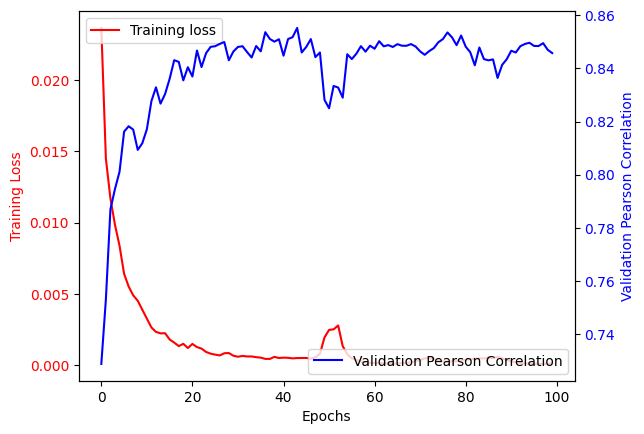

In [172]:
import time
from torchsummary import summary
import os
timestamp = time.strftime('%Y%m%d_%H%M%S')
save_dir = f'D:/01IscBML/logfile/{timestamp}/'
os.mkdir(save_dir)
# Initialize the model, loss function, and optimizer
model = LocalCNN(sequence_length = sequence_length)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and validation setup
num_epochs = 100  # Adjust as needed

# Function to calculate Pearson correlation coefficient
def pearson_correlation(predicted, actual):
    pred_mean = predicted.mean()
    actual_mean = actual.mean()
    covariance = ((predicted - pred_mean) * (actual - actual_mean)).sum()
    pred_std = ((predicted - pred_mean) ** 2).sum().sqrt()
    actual_std = ((actual - actual_mean) ** 2).sum().sqrt()
    return (covariance / (pred_std * actual_std)).item()

plot_loss = []
plot_pearson = []
max_r = 0.0
for epoch in range(num_epochs):
    if epoch == 0:  # Save the architecture only in the first epoch
        ## for MLP
        input_size = sequence_length * channel
        model_architecture = summary(model, input_size=(sequence_length, channel))
    model.train()  # Set model to training mode
    running_loss = 0.0

    train_pearson = 0.0  # To accumulate Pearson correlation coefficient for training
    
    # Training loop
    for batch_features, batch_labels in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        # Move data to appropriate device (e.g., GPU if available)
        batch_features, batch_labels = batch_features.to('cpu'), batch_labels.to('cpu')
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calculate Pearson correlation for the batch
        predicted = outputs.squeeze(1)  # Remove singleton dimension
        actual = batch_labels.squeeze(1)
        train_pearson += pearson_correlation(predicted, actual)

    # Compute average training loss and Pearson correlation for the epoch
    epoch_loss = running_loss / len(train_dataloader)
    plot_loss.append(epoch_loss)
    epoch_train_pearson = train_pearson / len(train_dataloader)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_pearson = 0.0
    with torch.no_grad():
        for val_features, val_labels in val_dataloader:  # Use a separate validation DataLoader
            val_features, val_labels = val_features.to('cpu'), val_labels.to('cpu')
            
            val_outputs = model(val_features)
            predicted = val_outputs.squeeze(1)
            # print(predicted)
            actual = val_labels.squeeze(1)
            # print(actual)

            # Calculate Pearson correlation for the validation set
            val_pearson += pearson_correlation(predicted, actual)
    
    # Compute average validation Pearson correlation for the epoch
    epoch_val_pearson = val_pearson / len(val_dataloader)
    plot_pearson.append(epoch_val_pearson)

    ##save the model and architecture
    if epoch_val_pearson > max_r:
        max_r = epoch_val_pearson
        model_name = model.__class__.__name__
        save_model_path = f'{save_dir}{model_name}.pth'
        model_architecture = summary(model, input_size=(sequence_length,channel))
        torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    # 'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss,
                    'architecture': model_architecture,
                    }, save_model_path)
          
    print(f"Model saved with Pearson correlation: {max_r:.4f}")

    # Print training and validation metrics
    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    print(f"Training Loss: {epoch_loss:.4f}")
    print(f"Validation Pearson Correlation: {epoch_val_pearson:.4f}")

plt.figure()
# plt.switch_backend('agg')
fig, ax1 = plt.subplots()

# model.predict()

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Loss', color='r')
ax1.plot(range(num_epochs), plot_loss, 'r', label='Training loss')
ax1.tick_params(axis='y', labelcolor='r')

ax2 = ax1.twinx()
ax2.set_ylabel('Validation Pearson Correlation', color='b')
ax2.plot(range(num_epochs), plot_pearson, 'b', label='Validation Pearson Correlation')
ax2.tick_params(axis='y', labelcolor='b')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
# plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
# plt.show()
file_path = os.path.join(save_dir, 'loss_plot_MLP.png')
plt.savefig(file_path)


In [173]:
#------------------test dataset---------------------
from torch.utils.data import random_split, DataLoader

test_label_data = FeatureProcessor(file_path='D:/01IscBML/',file_name='test.xlsx').labels_tensor
test_combined_features = FeatureProcessor(file_path='D:/01IscBML/',file_name='test.xlsx').combined_features
#---------------------Create dataset and dataloader-----------------
dataset = TensorDataset(test_combined_features, test_label_data)
testset_length = len(dataset)
print(testset_length)

# Turn shuffle to False if you want to keep the predefined order of the data
test_dataloader = DataLoader(dataset, batch_size=testset_length, shuffle=False) 



6969


In [174]:
###---------test the model----------------
import torch
import pandas as pd

# Set the model to evaluation mode
model.eval()

# Initialize variables for tracking
test_results = []  # To store results for each test sample
test_pearson = 0.0

with torch.no_grad():  # Disable gradient computation for evaluation
    for test_features, test_labels in test_dataloader:  # Use the test DataLoader
        # Move data to the appropriate device (e.g., CPU)
        test_features, test_labels = test_features.to('cpu'), test_labels.to('cpu')
        
        # Perform predictions
        test_outputs = model(test_features)
        predicted = test_outputs.squeeze(1)  # Detach to numpy for processing
        actual = test_labels.squeeze(1)

        # Store each prediction with its actual label
        for pred, act in zip(predicted, actual):
            test_results.append({'Predicted': pred.item(), 'Actual': act.item()})
        
        # Calculate Pearson correlation for this batch
        test_pearson += pearson_correlation(predicted, actual)

# Compute average test Pearson correlation
avg_test_pearson = test_pearson / len(test_dataloader)
print(f"Average Test Pearson Correlation: {avg_test_pearson}")

# Save test results to a DataFrame and export to a CSV file
results_df = pd.DataFrame(test_results)
test_result_path = f'{save_dir}{timestamp}.csv'
results_df.to_csv(f'{save_dir}{timestamp}.csv', index=False)
print("Test results saved to 'test_results.csv'.")


Average Test Pearson Correlation: 0.8555132746696472
Test results saved to 'test_results.csv'.


In [187]:
model_architecture = str(summary(model, input_size=(sequence_length,channel)))
print(model_architecture)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 56]           3,392
              ReLU-2               [-1, 32, 56]               0
            Conv1d-3               [-1, 32, 56]          21,536
              ReLU-4               [-1, 32, 56]               0
            Conv1d-5               [-1, 32, 56]          21,536
            Linear-6                  [-1, 128]         229,504
              ReLU-7                  [-1, 128]               0
            Linear-8                   [-1, 32]           4,128
          Hardtanh-9                   [-1, 32]               0
           Linear-10                    [-1, 1]              33
Total params: 280,129
Trainable params: 280,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 1.07
Estimated T

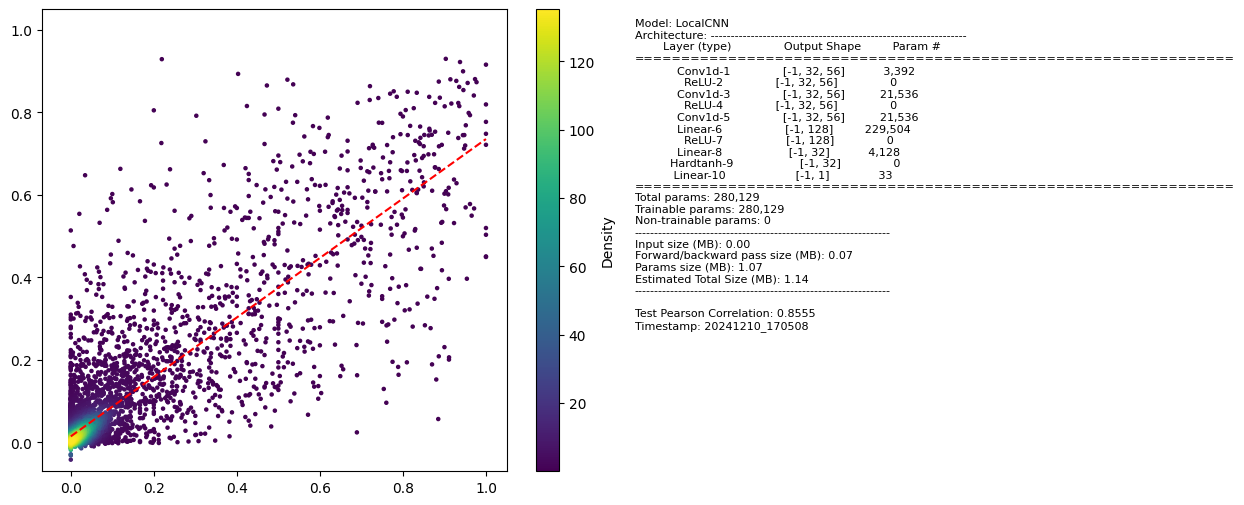

In [ ]:
##draw the correlation
import os
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import matplotlib.gridspec as gridspec
import io
import contextlib

# Example data: Replace these with your lists
test_results = pd.read_csv(test_result_path)
actual = test_results['Actual'].values
predicted = test_results['Predicted'].values

# Calculate point density using Gaussian KDE
xy = np.vstack([actual, predicted])
density = gaussian_kde(xy)(xy)
# Sort points by density for better visualization
sorted_indices = density.argsort()
actual_sorted = actual[sorted_indices]
predicted_sorted = predicted[sorted_indices]
density_sorted = density[sorted_indices]

# Create the plot
plt.figure(figsize=(15, 6))
# Create a grid layout: 1 row, 2 columns
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 2])

scatter = plt.subplot(gs[0,0])
scatter = plt.scatter(
    actual_sorted,
    predicted_sorted,
    c=density_sorted,
    cmap='viridis',
    s=5,
    label='Data Points'
)
plt.colorbar(scatter, label='Density')

# Add regression line
plt.plot(
    np.unique(actual),
    np.poly1d(np.polyfit(actual, predicted, 1))(np.unique(actual)),
    color='red',
    linestyle='--',
    label='Regression Line'
)
plt.xlim(-0.07, 1.2)
plt.ylim(-0.07, 1.2)

#####-----------------add the model architecture-----------------
buffer = io.StringIO()
with contextlib.redirect_stdout(buffer):
    summary(model, input_size=(sequence_length,channel))
output = buffer.getvalue()

ax_text = plt.subplot(gs[0,1])  # Use the second section of the grid
ax_text.axis('off')  # Turn off the axes for the text area
info_text = f"Model: {model.__class__.__name__}\n" \
            f"Architecture: {output}\n" \
            f"Test Pearson Correlation: {avg_test_pearson:.4f}\n" \
            f"Timestamp: {timestamp}"
plt.text(0.02, 0.98, info_text, transform=plt.gca().transAxes, fontsize=8, verticalalignment='top')
plt.subplots_adjust(wspace=0)
save_path = os.path.join(save_dir, f"{timestamp}_{avg_test_pearson}.png")
plt.savefig(save_dir+f'{timestamp}_{avg_test_pearson}.png')


In [177]:
from torchsummary import summary
import torch.nn as nn
import contextlib
import io
with open(f"{save_dir}"+f"{timestamp}.txt", "w") as f:
    buffer = io.StringIO()
    with contextlib.redirect_stdout(buffer):
        summary(model, input_size=(sequence_length,channel))
    f.write(buffer.getvalue())

In [178]:
# import torch
# import torch.nn as nn
# import torch.optim as optim

# # Define a simple 1D CNN model
# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()
#         self.conv1 = nn.Conv1d(in_channels=4, out_channels=16, kernel_size=3, padding=1)
#         self.relu = nn.ReLU()
#         self.pool = nn.MaxPool1d(kernel_size=2)
#         self.fc1 = nn.Linear(16 * (56 // 2), 1)  # Assuming sequence length is 56 after pooling
        
#     def forward(self, x):
#         x = x.permute(0, 2, 1)  # Change shape to (batch_size, channels, sequence_length)
#         x = self.conv1(x)
#         x = self.relu(x)
#         x = self.pool(x)
#         x = x.view(x.size(0), -1)  # Flatten
#         x = self.fc1(x)
#         return x

In [179]:
"""class dataloader

class IscBDataset(Dataset):
    def __init__(self):
        super(IscBDataset,self).__init__()
        xy = truncated_simple_df.to_numpy(dtype=np.float64)[:,1:]
        self.x = torch.from_numpy(xy[0]) #convert numpy into torch tensor
        self.y = torch.from_numpy(xy[1])
        ###for scaler standardize features
        # self.scaler = StandardScaler()  #standardized_value = (value - mean)/standard deviation
        # self.x = torch.from_numpy(self.scaler.fit_transform(self.x))
        self.n_samples = len(xy)

    def __getitem__(self, index) :
        return self.x[index], self.y[index]

    def __len__(self):
        return self.n_samples

dataset = IscBDataset()
data_Loader = DataLoader(dataset=dataset, shuffle = True) #(batch_size = batch_size)

"""

'class dataloader\n\nclass IscBDataset(Dataset):\n    def __init__(self):\n        super(IscBDataset,self).__init__()\n        xy = truncated_simple_df.to_numpy(dtype=np.float64)[:,1:]\n        self.x = torch.from_numpy(xy[0]) #convert numpy into torch tensor\n        self.y = torch.from_numpy(xy[1])\n        ###for scaler standardize features\n        # self.scaler = StandardScaler()  #standardized_value = (value - mean)/standard deviation\n        # self.x = torch.from_numpy(self.scaler.fit_transform(self.x))\n        self.n_samples = len(xy)\n\n    def __getitem__(self, index) :\n        return self.x[index], self.y[index]\n\n    def __len__(self):\n        return self.n_samples\n\ndataset = IscBDataset()\ndata_Loader = DataLoader(dataset=dataset, shuffle = True) #(batch_size = batch_size)\n\n'